# Imports

In [1]:
import numpy as np
import glob
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
from scipy.ndimage import interpolation

# Reading data

Taking the input images as 48x48. One of the challenges in this dataset was that the digit 1 and 4 look really similar. Thus, increasing the image size to 48x48 increases the accuracy as well as doesn't adds much extra time in model training in comparison with 64x64.

In [2]:
X_train = np.zeros((60000,48,48)).astype('float32')

for label in range(1,11):
    filenames = glob.glob("data/train/" + str(label) + "/*.jpg")
    filenames.sort()
    images = [cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in filenames]
    images = [cv2.resize(img, (48, 48)) for img in images]
    X_train[6000*(label-1):(6000*label)] = images

In [33]:
#Reading test images
filenames = glob.glob("data/test/test/*.jpg")
filenames.sort()
X_test = [cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in filenames]
X_test = [cv2.resize(img, (48, 48)) for img in X_test]
X_test = np.array(X_test).astype('float32')

In [4]:
print('Shape of training data',np.shape(X_train))
print('Shape of testing data',np.shape(X_test))

Shape of training data (60000, 48, 48)
Shape of testing data (10000, 48, 48)


In [5]:
y_train = np.ones(60000).astype('int')
for i in range(10):
    y_train[6000*i:6000*(i+1)] = str(i+1)

# to_categorical divides the data to categories i.e 
y_train = to_categorical(y_train-1,num_classes=10)
print('Shape of labels',np.shape(y_train))

Shape of labels (60000, 10)


# Data format


 Let's see how the 10 digits of the ethiopic digit recognits looks like:

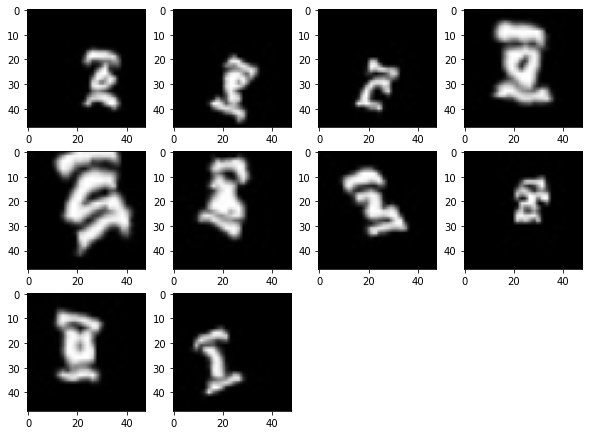

In [6]:
plt.figure(figsize=(10,10))
for i in range(0,60000,6000):
    plt.subplot(4,4, i/6000+1)
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))

Now if we look at the test data and compare it to train images, we will observe that the images in test data seems to be zoomed in and placed in centre:

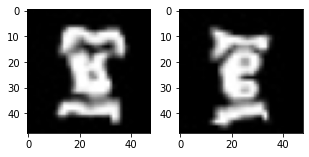

In [7]:
plt.figure(figsize=(5,5))
for i in range(0,10000,5000):
    plt.subplot(2,2, i/5000+1)
    plt.imshow(X_test[i], cmap = plt.get_cmap('gray'))

# Data pre processing

Keeping the test images in mind, we have deskewed the training images to place the digits in center and to try to rotate then as straight as possible. 

In [8]:
def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)


def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

In [9]:
def deskewAll(X):
    currents = []
    for i in range(len(X)):
        currents.append(deskew(X[i].reshape(48,48)).flatten())
    return np.array(currents)

dewskew_train_image = deskewAll(X_train)

Some examples of deskewed images:

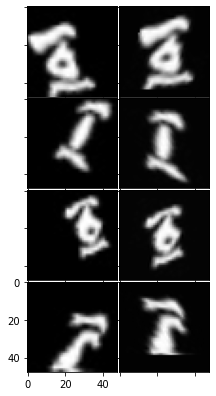

In [11]:
examples = (1000, 0), (56000,1),(1444,2),(12444,3)
from mpl_toolkits.axes_grid1 import AxesGrid
grid = AxesGrid(plt.figure(figsize=(15,15)), 141,
                    nrows_ncols=(4, 2),
                    label_mode="1",
                    )

for examplenum,num in examples:
    im = grid[2*num].imshow(X_train[examplenum].reshape(48,48),cmap = plt.get_cmap('gray'))
    im2 = grid[2*num+1].imshow(dewskew_train_image[examplenum].reshape(48,48),cmap = plt.get_cmap('gray'))

Deskewing the images turned out to be the key factor in getting to full accuracy. As for the data augmentation, we have further tried to zoom the deskewed images for model training.

In [12]:
#data augmentation
gen = ImageDataGenerator(
    zoom_range=.4,
    horizontal_flip=True)

In [13]:
X_train = dewskew_train_image

In [15]:
X_train = X_train.reshape(-1,48,48,1)
X_test = X_test.reshape(-1,48,48,1)

# Model

In [16]:
def mish(x):
    return x * keras.backend.tanh(keras.backend.softplus(x))

In [51]:
model_count = 5
model = [0] * model_count
for i in range(model_count):
    model[i] = Sequential()

    model[i].add(Conv2D(48, kernel_size = 3, activation=mish,  input_shape = (48, 48, 1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(48, kernel_size = 3, activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(48, kernel_size = 5, strides=2, padding='same', activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))

    model[i].add(Conv2D(96, kernel_size = 3,  activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(96, kernel_size = 3, activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(96, kernel_size = 5,strides=2, padding='same', activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))
    model[i].add(Flatten())
    
    model[i].add(Dense(384 ,activation=mish))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4)) 
    model[i].add(Dense(10, activation='softmax'))

    model[i].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [52]:
model[0].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 46, 46, 48)        480       
_________________________________________________________________
batch_normalization_21 (Batc (None, 46, 46, 48)        192       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 44, 44, 48)        20784     
_________________________________________________________________
batch_normalization_22 (Batc (None, 44, 44, 48)        192       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 48)        57648     
_________________________________________________________________
batch_normalization_23 (Batc (None, 22, 22, 48)        192       
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 48)       

In [53]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# Training 3 CNN models
history = [0] * model_count
epochs = 110

for i in range(model_count):
    X_train_net, X_val_net, y_train_net, y_val_net_ = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)
    history[i] = model[i].fit_generator(gen.flow(X_train_net,y_train_net, batch_size=64),epochs = epochs,
                                        steps_per_epoch = X_train_net.shape[0]//64,          
                                        validation_data = (X_val_net,y_val_net_), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        i+1,epochs,max(history[i].history['accuracy']),max(history[i].history['val_accuracy']) ))

CNN 1: Epochs=110, Train accuracy=0.99978, Validation accuracy=0.99917
CNN 2: Epochs=110, Train accuracy=0.99970, Validation accuracy=0.99900
CNN 3: Epochs=110, Train accuracy=0.99978, Validation accuracy=0.99917
CNN 4: Epochs=110, Train accuracy=0.99972, Validation accuracy=0.99950
CNN 5: Epochs=110, Train accuracy=0.99983, Validation accuracy=0.99967


# Post processing

Ploting the loss and accuracy curves for training and validation of first model

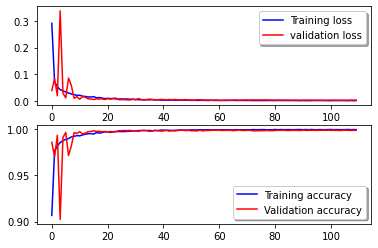

In [54]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history[0].history['loss'], color='b', label="Training loss")
ax[0].plot(history[0].history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history[0].history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history[0].history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Enesembling the models and taking the mode 

In [76]:
results = np.zeros( (X_test.shape[0],10) ) 
for i in range(3):
    results = results + model[i].predict(X_test.reshape(-1,48,48,1))
results = np.argmax(results,axis = 1)
results+1

array([ 9,  1,  1, ..., 10, 10,  3])

In [75]:
# Saving submission
submission_count = len(glob.glob('submissions/' + '*csv'))
with open("submissions/submission_" + str(submission_count+1) + ".csv", "w") as fp:
    fp.write("Id,Category\n") 
    for idx in range(10000): 
        fp.write(f"{idx:05},{(results[idx])+1}\n") 